In [134]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

# json_file = 'Data\D1_flexion_golden_repetition.json'
# json_file = 'Data\python_lbue4-loop_720p_flip.json'
# json_file = 'Data\python_md54-side-loop_720p_flip.json'
# json_file = 'Data\python_md55-loop_720p_flip.json'
json_file = 'Data\squat_golden_repetition.json'
# json_file = '/content/jitter.json'
# json_file = 'Data\jitter.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)


In [135]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    try:
        for timestamp in data['golden_rep_poses']:
            positions = timestamp['pose']
            list_of_tuples_for_each_timestamp = [
                [positions[i], positions[i+1]] for i in range(0, 34, 2)
            ]
            list_of_positions.append(list_of_tuples_for_each_timestamp)
    except:
        pose_data = data["golden_video_metadata"]["pose"]

        for pose in pose_data:
            pose = pose[1:] # first element is a time
            list_of_tuples_for_each_pose = [
                [pose[i], pose[i+1]] for i in range(0, 34, 2)
            ]
            list_of_positions.append(list_of_tuples_for_each_pose)

    return list_of_positions


def differecne_measurment(list_of_positions, reference_node, body_parts):
    """Comes in handy whenever actor flies over the screen"""
    reference_index = body_parts[reference_node]
    for frame in list_of_positions:
        ref_x = frame[reference_index][0]
        ref_y = frame[reference_index][1]
        for node in frame:
            node[0] -= (ref_x - 0.5)
            node[1] -= (ref_y - 0.5)
    return list_of_positions

def transform_list_of_positions(list_of_positions, scale_to_pixels=True):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            if scale_to_pixels:
                node[0] = int(node[0]*720)
                node[1] = int(node[1]*1280)
            # print(node)

    return list_of_positions

def smooth_positions(list_of_positions, window_size=5):
    """Applies a moving average filter to smooth the positions of each node over time."""
    smoothed_positions = []
    for i in range(len(list_of_positions)):
        if i < window_size:
            smoothed_positions.append(list_of_positions[i])
        else:
            smoothed_frame = []
            for j in range(len(list_of_positions[i])):
                smoothed_x = np.mean([list_of_positions[k][j][0] for k in range(i-window_size, i+1)])
                smoothed_y = np.mean([list_of_positions[k][j][1] for k in range(i-window_size, i+1)])
                smoothed_frame.append([smoothed_x, smoothed_y])
            smoothed_positions.append(smoothed_frame)
    return smoothed_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


import math
def get_angle(A, B, C, list_of_positions, body_parts):
    angles = []
    for frame in list_of_positions:
        a = frame[body_parts[A]]
        b = frame[body_parts[B]]
        c = frame[body_parts[C]]

        BA = [a[0] - b[0], a[1] - b[1]]
        BC = [c[0] - b[0], c[1] - b[1]]
        
        # Dot product of BA and BC
        dot_product = BA[0] * BC[0] + BA[1] * BC[1]
        
        # Magnitudes of BA and BC
        magnitude_BA = math.sqrt(BA[0]**2 + BA[1]**2)
        magnitude_BC = math.sqrt(BC[0]**2 + BC[1]**2)
        
        # Cosine of the angle
        cos_angle = dot_product / (magnitude_BA * magnitude_BC)
        
        # Angle in radians
        angle_radians = math.acos(cos_angle)
        
        # Convert to degrees
        angle_degrees = math.degrees(angle_radians)
        angles.append(angle_degrees)

    return angles

HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]

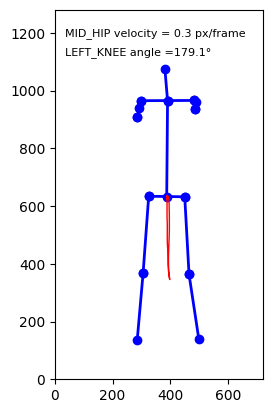

In [136]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)
# list_of_positions = differecne_measurment(list_of_positions, 'LEFT_HIP', body_parts)

# Smooth the positions
list_of_positions = smooth_positions(list_of_positions, window_size=5)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')
add_fake_point_between_A_and_B('RIGHT_SHOULDER', 'LEFT_SHOULDER', list_of_positions, body_parts, 'MID_SHOULDER')



# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'MID_SHOULDER'))
HUMAN_BLUEPRINT.append(('MID_SHOULDER', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('MID_HIP', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
velocity = np.sqrt(x_vel**2 + y_vel**2)


angles = get_angle('LEFT_FOOT', 'LEFT_KNEE', 'LEFT_HIP', list_of_positions, body_parts)

fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlim(0, 720)
ax.set_ylim(0, 1280)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')
angle_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')

def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)

    if i < len(trace):
        trace_x = [pos[0] for pos in trace[:i+1]]
        trace_y = [pos[1] for pos in trace[:i+1]]
        trace_line.set_data(trace_x, trace_y)

    current_angle = angles[i]
    angle_text.set_text(f'LEFT_KNEE angle ={round(current_angle, 1)}°')
    
    angle_text.set_position((0.05, 0.9))
    velocity_text.set_position((0.05, .95))


    current_velocity = velocity[i]
    velocity_text.set_text(f'MID_HIP velocity = {round(current_velocity, 1)} px/frame')
    
    # Position the velocity text in the upper right corner
    # velocity_text.set_position((trace_x[-1]/720, trace_y[-1]/1280))

    return lines + [trace_line]


# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
# os.makedirs('Animations', exist_ok=True)
gif_path = 'Animations/'+json_file[5:-5] + '_animation.gif'
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

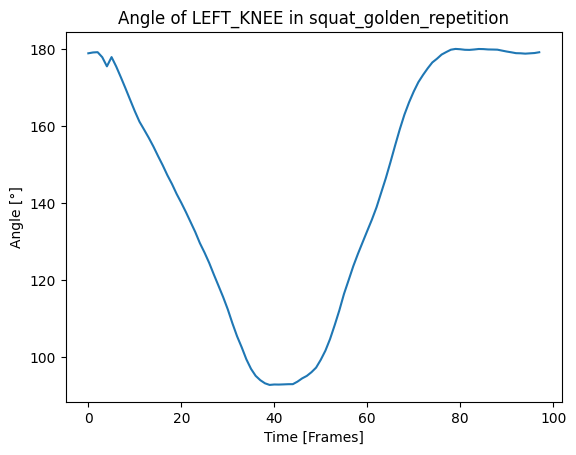

In [137]:
plt.title(f'Angle of LEFT_KNEE in {json_file[5:-5]}')
plt.plot(angles)
plt.xlabel('Time [Frames]')
plt.ylabel('Angle [°]')

plt.savefig(f'Plots/Angle of LEFT_KNEE in {json_file[5:-5]}.png')


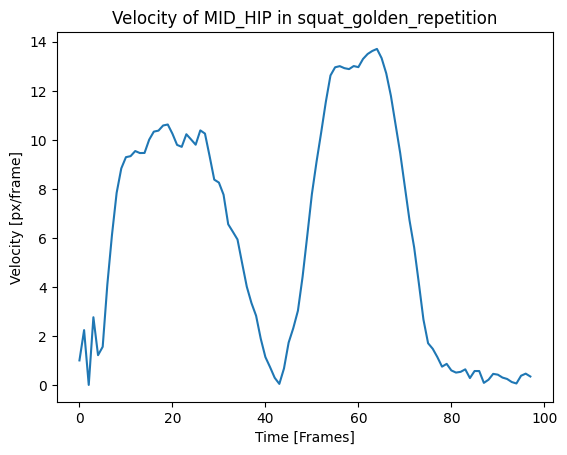

In [138]:

plt.title(f'Velocity of MID_HIP in {json_file[5:-5]}')
plt.plot(velocity)
plt.xlabel('Time [Frames]')
plt.ylabel('Velocity [px/frame]')

plt.savefig(f'Plots/Velocity of MID_HIP in {json_file[5:-5]}.png')